# Passenger versus train punctuality 

We first read the CSV files that were exported using viz_main_merge.ipnyb. The file contain the merged traffic and demand data.

In [1]:
import pandas as pd

# Read the CSV file
#df_onboard_planned = pd.read_csv('df_onboard_planned.csv')
df_onboard = pd.read_csv('df_onboard_actual.csv')

We want to compare the train and punctuality and passenger punctuality. We first prepare the train punctuality.

## Train punctuality

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a range of delay thresholds up to 30 minutes
max_min = 16
delay_thresholds = np.linspace(0, max_min-1, 100)


# Calculate the share of trains within the threshold
total_valid_arrivals = df_onboard[df_onboard['UppehallstypAnkomst'] == "Sista"]['Ankomsttid'].count()
OTP_within_threshold = []
for threshold in delay_thresholds:
    # number of arrivals to final station within threshold (in minutes)
    num_within_threshold = len(df_onboard[(df_onboard['UppehallstypAnkomst'] == "Sista") 
                                             & (df_onboard['Ankomsttid'].notna()) 
                                             & (df_onboard['arr_delay_minutes'] <= threshold)])
    OTP_within_threshold.append((num_within_threshold / total_valid_arrivals) * 100)

Let us plot the train punctuality alone!

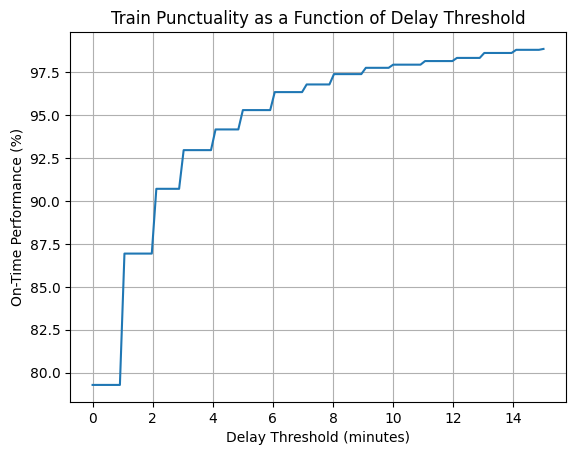

In [3]:
# Plot the train punctuality as a function of the delay threshold
plt.plot(delay_thresholds, OTP_within_threshold)
plt.xlabel('Delay Threshold (minutes)')
plt.ylabel('On-Time Performance (%)')
plt.title('Train Punctuality as a Function of Delay Threshold')
plt.grid(True)
plt.show()

## Passenger punctuality

Let us now calculate the share of passenger arriving to their destination stations with a certain threshold.

In [4]:
# Calculate the total number of passengers travelling
total_pax_arrivals = df_onboard.n_alighting_next.sum()

# Calculate the share of passengers arriving within the threshold
PP_within_threshold = []
for threshold in delay_thresholds:
    # number of arrivals to final station within threshold (in minutes)    
    pax_within_threshold = df_onboard[(df_onboard["arr_delay_minutes"] <= threshold)
                                      & df_onboard['Ankomsttid'].notna()]['n_alighting_next'].sum()
    PP_within_threshold.append((pax_within_threshold / total_pax_arrivals) * 100)

Plot both passenger and train punctuality.

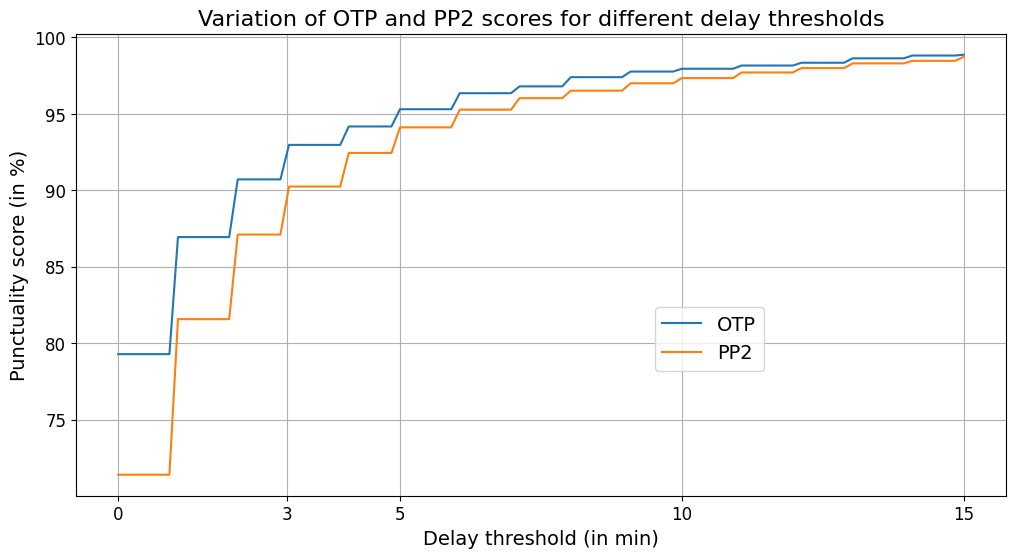

In [5]:
# Plot the train punctuality as a function of the delay threshold
plt.figure(figsize=(12, 6))
plt.plot(delay_thresholds, OTP_within_threshold, label='OTP')
plt.plot(delay_thresholds, PP_within_threshold, label='PP2')
plt.xlabel('Delay threshold (in min)', fontsize=14)
plt.ylabel('Punctuality score (in %)', fontsize=14)
plt.title('Variation of OTP and PP2 scores for different delay thresholds', fontsize=16)
plt.legend(loc='lower right', fontsize=14, bbox_to_anchor=(.75, 0.25))
ticks = list(range(0, max_min, 5))
# Add tick at 3
ticks.append(3)
# Sort the ticks to maintain order
ticks.sort()
# Set the ticks on the x-axis
plt.xticks(ticks, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

## OTP and PP2 for different delay thresholds

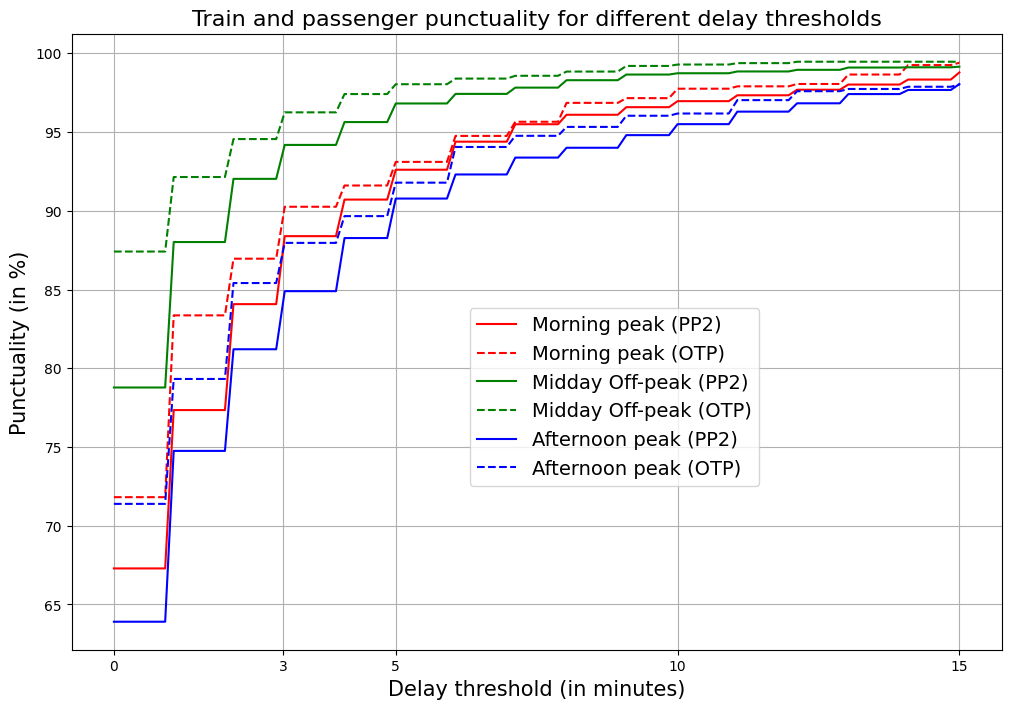

In [6]:
# Categorize hours into specific periods
df_onboard['Ankomsttid'] = pd.to_datetime(df_onboard['Ankomsttid'], errors='coerce')
df_onboard['Hour'] = df_onboard['Ankomsttid'].dt.hour
hour_bins = [6, 9, 15, 18]
hour_labels = ['Morning peak', 'Midday Off-peak', 'Afternoon peak']
colors = ['red', 'green', 'blue']

# Use pd.cut to categorize each hour into the appropriate period
df_onboard['Hour Period'] = pd.cut(df_onboard['Hour'], bins=hour_bins, labels=hour_labels, ordered=False)

# Calculate average OTP and PP for each hour period
df_hourly_OTP = pd.DataFrame(columns=['OTP Percentage'], index=hour_labels)
df_hourly_PP = pd.DataFrame(columns=['PP Percentage'], index=hour_labels)

for period in hour_labels:
    # Filter data for the current hour period and calculate OTP and PP percentages
    period_data = df_onboard[df_onboard['Hour Period'] == period]
    OTP_percentage = []
    PP_percentage = []
    total_pax_arrivals = period_data['n_alighting_next'].sum()
    total_num_arrivals = len(period_data[(period_data['UppehallstypAnkomst'] == "Sista") 
                             & (period_data['Ankomsttid'].notna())])
    
    for threshold in delay_thresholds:
        num_within_threshold = np.sum((period_data['arr_delay_minutes'] <= threshold)
                                      & (period_data['UppehallstypAnkomst'] == "Sista")
                                      & (period_data['Ankomsttid'].notna()))
        
        OTP_percentage.append((num_within_threshold / total_num_arrivals) * 100)
        
        pax_within_threshold = period_data[(period_data["arr_delay_minutes"] <= threshold)
                                           & (period_data['Ankomsttid'].notna())]['n_alighting_next'].sum()
        PP_percentage.append((pax_within_threshold / total_pax_arrivals) * 100)
    
    df_hourly_OTP.loc[period, 'OTP Percentage'] = OTP_percentage
    df_hourly_PP.loc[period, 'PP Percentage'] = PP_percentage

# Plotting hourly variation OTP and PP
plt.figure(figsize=(12, 8))
for i, period in enumerate(hour_labels):
    plt.plot(delay_thresholds, df_hourly_PP.loc[period, 'PP Percentage'], label=f'{period} (PP2)', color=colors[i], linestyle='-')
    plt.plot(delay_thresholds, df_hourly_OTP.loc[period, 'OTP Percentage'], label=f'{period} (OTP)', color=colors[i], linestyle='--')

plt.xlabel('Delay threshold (in minutes)', fontsize=15)
plt.ylabel('Punctuality (in %)', fontsize=15)
plt.title('Train and passenger punctuality for different delay thresholds', fontsize=16)
plt.legend(loc='lower right', fontsize=14, bbox_to_anchor=(.75, 0.25))
plt.xticks(ticks)
plt.grid(True)
plt.show()

## Scatter plot (PP2, OTP) different time periods - planned ridership

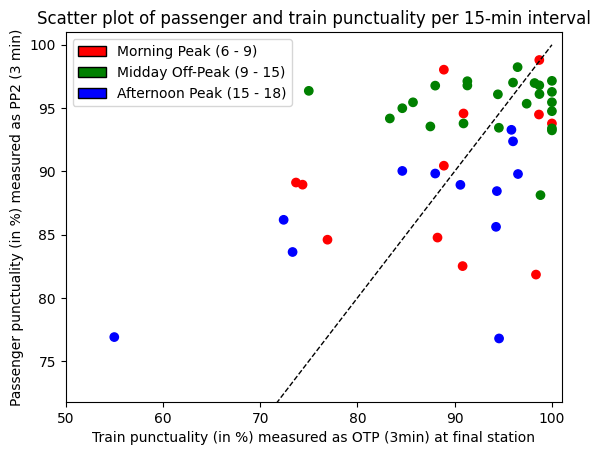

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# 1. Define the OTP and PP2 functions based on a 3-minute threshold
threshold_minutes = 3

# OTP: Percentage of trains that depart within the 3-minute threshold
df_onboard.loc[:, 'OTP_all'] = (df_onboard['arr_delay_minutes'] <= threshold_minutes) & (df_onboard['Ankomsttid'].notna())

# PP2: Percentage of passengers that are on-time, considering the 3-minute threshold
df_onboard.loc[:, 'PP2'] = ((df_onboard['arr_delay_minutes'] <= threshold_minutes) & (df_onboard['Ankomsttid'].notna())) * df_onboard['n_alighting_next']  # df_onboard['n_onboard']

df_onboard.loc[:, 'time_period'] = df_onboard['arr_t_float'].astype(int)

# Group by time_period (or another suitable time grouping) to aggregate OTP and PP2
df_grouped = df_onboard.groupby('time_period').agg({
    'OTP_all': lambda x: x[df_onboard['UppehallstypAnkomst'] == 'Sista'].mean(),
    'PP2': 'sum',
    # 'n_onboard': 'sum'
    'n_alighting_next': 'sum'
}).reset_index()

# Calculate the percentage of passengers on-time (PP2)
df_grouped['PP2'] = df_grouped['PP2'] / df_grouped['n_alighting_next']

# 2. Define the time periods for peak and off-peak hours
peak_morning = range(6 * 4, 9 * 4)  # 6 AM to 9 AM
off_peak_midday = range(9 * 4, 15 * 4)  # 9 AM to 3 PM
peak_afternoon = range(15 * 4, 18 * 4)  # 3 PM to 6 PM

# Assign colors based on time period
colors = []
filtered_df = df_grouped[df_grouped['time_period'].isin(peak_morning) | df_grouped['time_period'].isin(off_peak_midday) | df_grouped['time_period'].isin(peak_afternoon)]
for time_period in filtered_df['time_period']:
    if time_period in peak_morning:
        colors.append('red')  # Morning peak
    elif time_period in off_peak_midday:
        colors.append('green')  # Off-peak midday
    elif time_period in peak_afternoon:
        colors.append('blue')  # Afternoon peak

# 3. Create scatter plot
plt.scatter(100 * filtered_df['OTP_all'], 100 * filtered_df['PP2'], c=colors)
plt.xlabel('Train punctuality (in %) measured as OTP (3min) at final station')
plt.ylabel('Passenger punctuality (in %) measured as PP2 (3 min)')
plt.title('Scatter plot of passenger and train punctuality per 15-min interval')

# Plot the y=x line
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1)

# Set limits for x and y axes based on the range of your data points
plt.xlim(filtered_df['OTP_all'].min() * 100-5, filtered_df['OTP_all'].max() * 100+1)
plt.ylim(filtered_df['PP2'].min() * 100-5, filtered_df['OTP_all'].max() * 100+1)

# Create legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Morning Peak (6 - 9)'),
    Patch(facecolor='green', edgecolor='black', label='Midday Off-Peak (9 - 15)'),
    Patch(facecolor='blue', edgecolor='black', label='Afternoon Peak (15 - 18)')
]

plt.legend(handles=legend_elements, loc='upper left')

# Show plot
plt.show()